<a href="https://colab.research.google.com/github/jaspersprakel/queueing_book/blob/master/notebooks/emas_case1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Assignment Data Science

**Introduction**

The rise of short-term rental platforms like Airbnb has transformed the hospitality industry, offering travelers a wide range of accommodation options while enabling property owners to monetize their spaces. However, determining the appropriate price for an Airbnb listing remains a challenge, as it depends on multiple factors such as location, property type, amenities, and seasonal demand. Understanding how these factors influence listing prices can provide valuable insights for hosts looking to optimize their pricing strategy and for potential guests seeking cost-effective accommodations.

In this project, we leverage machine learning techniques to analyze Airbnb listings in New York City. Using publicly available data from the Inside Airbnb dataset, we aim to identify key factors that impact listing prices and develop predictive models to estimate price variations. By applying statistical and machine learning methods—including logistic regression, decision trees, random forests, and XGBoost—we will assess which features contribute the most to price fluctuations and evaluate the accuracy of different predictive models.

The significance of this analysis extends beyond individual hosts and travelers. It can offer valuable insights for property managers, urban planners, and policymakers by highlighting market trends and potential pricing disparities across neighborhoods. Additionally, understanding the pricing dynamics in the short-term rental market can help stakeholders make data-driven decisions regarding property investments and regulatory policies.

This report is structured as follows: we begin by exploring and preprocessing the dataset, addressing missing values, and performing feature engineering. Next, we implement various machine learning models to predict listing prices, followed by an evaluation of their performance. Finally, we discuss the key findings, potential limitations, and avenues for further research. Through this analysis, we aim to demonstrate the practical application of data science techniques in real-world economic and business contexts.

In [1]:
%%capture
!git clone https://github.com/ramonVDAKKER/teaching-data-science-emas
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!jupyter nbextension enable --py widgetsnbextension
#test

**Import packages**

In [2]:
import os
print(os.getcwd())
os.chdir("teaching-data-science-emas/notebooks")

/content


Important packages for Python are <a href="http://www.numpy.org/">numpy</a> (for arrays, linear algebra, pseudorandom numbers etc.), <a href="http://pandas.pydata.org/">pandas</a> (contains convenient data structure called "pandas dataframe"), <a href="http://matplotlib.org/">matplotlib</a> & <a href="http://seaborn.pydata.org/"> seaborn</a> (for data visualisation), <a href="http://scikit-learn.org/stable/">sklearn</a> (scikit-learn; powerful package containing machine & statistical learning functions), and  <a href="https://www.statsmodels.org/stable/index.html">statsmodels</a> for statistical models and routines.

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import ticker as ticker
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix,  accuracy_score, roc_auc_score, precision_recall_curve, RocCurveDisplay
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import xgboost as xgb

In [4]:
%matplotlib inline

## 1. Load dataset & Elementary Data Analysis

### 1.1 Load and inspect data

Load dataset into a pandas dataframe:

In [5]:
from google.colab import files
uploaded = files.upload()
import io
import pandas as pd

dataset = pd.read_csv(io.BytesIO(uploaded['listings 2.csv']))

#dataset = pd.read_csv("./data/case_1/DataTrain.csv")

Saving listings 2.csv to listings 2.csv


<ipython-input-5-0dfb0f2eaabb>:6: DtypeWarning: Columns (67) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(io.BytesIO(uploaded['listings 2.csv']))


The dataset is first split into a "train set" and a "validation set".

In [6]:
seed = 123
train_df, aux_df = train_test_split(dataset, train_size=.5, random_state=seed)
validation_df, test_df = train_test_split(aux_df, train_size=.5, random_state=seed)

print(f"data_train shape: {train_df.shape}")
print(f"data_validation shape: {validation_df.shape}")
print(f"data_test shape: {test_df.shape}")
del dataset

data_train shape: (18705, 74)
data_validation shape: (9352, 74)
data_test shape: (9353, 74)


Let us inspect the first 3 and the last 3 rows of the dataset:

In [7]:
pd.options.display.max_columns = 100
display(train_df.head(3))
display(train_df.tail(3))

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
8133,12686241,https://www.airbnb.com/rooms/12686241,20220603182654,2022-06-04,Large Front Facing Bedroom & Private Backyard,Large bedroom on Garden floor with backyard ac...,NaN,https://a0.muscache.com/pictures/58451700-6447...,30848788,https://www.airbnb.com/users/show/30848788,Jamie,2015-04-08,"De Kalb, Mississippi, United States",NaN,within a few hours,90%,75%,f,https://a0.muscache.com/im/pictures/user/706a1...,https://a0.muscache.com/im/pictures/user/706a1...,Bedford-Stuyvesant,2.0,2.0,"['email', 'phone']",t,t,NaN,Bedford-Stuyvesant,Brooklyn,40.69462,-73.94693,Private room in rental unit,Private room,2,NaN,1 shared bath,1.0,1.0,"[""Essentials"", ""Cooking basics"", ""Wifi"", ""Carb...",$125.00,4,150,4.0,4.0,150.0,150.0,4.0,150.0,NaN,t,29,59,89,89,2022-06-04,51,1,0,2016-05-11,2022-04-27,4.69,4.75,4.69,4.94,4.98,4.57,4.59,NaN,f,2,0,2,0,0.69
24373,45261941,https://www.airbnb.com/rooms/45261941,20220603182654,2022-06-03,A+ Location Classic Studio Suite(2 Double Beds),Our apartment is located in the center of Manh...,This is a very central location where you can ...,https://a0.muscache.com/pictures/d415db7b-95f0...,348619646,https://www.airbnb.com/users/show/348619646,Nomad,2020-06-03,"New York, New York, United States",We are delighted to accommodate you during you...,within an hour,100%,99%,f,https://a0.muscache.com/im/pictures/user/00285...,https://a0.muscache.com/im/pictures/user/00285...,NaN,55.0,55.0,"['email', 'phone']",t,t,"New York, United States",Midtown,Manhattan,40.74797,-73.98847,Entire rental unit,Entire home/apt,4,NaN,1 bath,NaN,2.0,"[""Conditioner"", ""Essentials"", ""Washer"", ""Cooki...",$276.00,1,1125,1.0,10.0,1125.0,1125.0,3.3,1125.0,NaN,t,10,34,64,276,2022-06-03,41,33,1,2020-09-06,2022-05-20,4.49,4.37,4.54,4.61,4.88,4.85,4.46,NaN,t,54,39,15,0,1.93
35726,602777088581961008,https://www.airbnb.com/rooms/602777088581961008,20220603182654,2022-06-03,Sweet SoHo 1 Bedroom,(AC works!) The best location in NYC! Steps fr...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,236369220,https://www.airbnb.com/users/show/236369220,Andrea,2019-01-13,"New York, New York, United States",NaN,within a day,75%,46%,f,https://a0.muscache.com/im/pictures/user/bb833...,https://a0.muscache.com/im/pictures/user/bb833...,NaN,0.0,0.0,"['email', 'phone']",t,t,NaN,Nolita,Manhattan,40.72136,-73.99617,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Wine glasses"", ""Essentials"", ""Cooking basics...",$283.00,6,40,6.0,28.0,40.0,40.0,8.7,40.0,NaN,t,8,8,8,8,2022-06-03,6,6,2,2022-04-16,2022-05-24,4.83,4.83,4.83,4.83,4.83,4.83,4.83,NaN,f,1,1,0,0,3.67


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
17730,32549155,https://www.airbnb.com/rooms/32549155,20220603182654,2022-06-04,BK Home Away From Home,Charming 2 bedroom apartment on top floor of w...,"Home of Junior's Cheesecake, Coney Island, Bar...",https://a0.muscache.com/pictures/85873401-13c6...,244596528,https://www.airbnb.com/users/show/244596528,Mary Ann,2019-02-21,"Brooklyn, New York, United States","Born and raised in Brooklyn, New York. Gradua...",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/69486...,https://a0.muscache.com/im/pictures/user/69486...,Bedford-Stuyvesant,1.0,1.0,"['email', 'phone']",t,t,"Brooklyn, New York, United States",Bedford-Stuyvesant,Brooklyn,40.69002,-73.934200,Entire rental unit,Entire home/apt,4,NaN,1 bath,2.0,2.0,"[""Essentials"", ""Extra pillows and blankets"", ""...",$109.00,2,27,2.0,2.0,27.0,27.0,2.0,27.0,NaN,t,1,1,1,24,2022-06-04,116,50,4,2019-05-07,2022-05-27,4.78,4.86,4.82,4.98,4.91,4.69,4.84,NaN,f,1,1,0,0,3.09
28030,50152840,https://www.airbnb.com/rooms/50152840,20220603182654,2022-06-04,A lovely smart home in Williamsburg-Greenpoint,Stay in a sun-filled apartment with smart-home...,North Brooklyn (Greenpoint/Williamsburg) – the...,https://a0.muscache.com/pictures/22f41221-7b98...,6796668,https://www.airbnb.com/users/show/6796668,Milan,2013-06-08,"New York, New York, United States",I’m a New York based design and branding profe...,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/9934d...,https://a0.muscache.com/im/pictures/user/9934d...,Williamsburg,1.0,1.0,"['email', 'phone']",t,t,"Brooklyn, New York, United States",Williamsburg,Brooklyn,40.71941,-73.943146,Entire condo,Entire home/apt,2,NaN,1 bath,1.0,2.0,"[""Baby monitor"", ""Table corner guards"", ""Wine ...",$200.00,31,365,31.0,31.0,365.0,365.0,31.0,365.0,NaN,t,0,0,0,69,2022-06-04,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
15725,28220182,https://www.airbnb.com/rooms/28220182,20220603182654,2022-06-04,New Charming 1 Bedroom Oasis Apartment,A Newly renovated fully furnished one bedroom ...,The neighborhood is historic and surrounded by...,https://a0.muscache.com/pictures/38fa5d92-4957...,35387196,https://www.airbnb.com/users/show/35387196,Kizzie,2015-06-09,"Brooklyn, New York, United States",NaN,within a few hours,80%,75%,f,https://a0.muscache.com/im/pictures/user/93ed6...,https://a0.muscache.com/im/pictures/user/93ed6...,Crown Heights,2.0,2.0,"['email', 'phone', 'work_email']",t,t,"Brooklyn, New York, United States",Prospect-Lefferts Gardens,Brooklyn,40.66130,-73.953650,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Carbon monoxide alarm"", ""Heating"", ""Essentia...",$110.00,7,365,7.0,7.0,365.0,365.0,7.0,365.0,NaN

Some meta-data:

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18705 entries, 8133 to 15725
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            18705 non-null  int64  
 1   listing_url                                   18705 non-null  object 
 2   scrape_id                                     18705 non-null  int64  
 3   last_scraped                                  18705 non-null  object 
 4   name                                          18699 non-null  object 
 5   description                                   18266 non-null  object 
 6   neighborhood_overview                         11155 non-null  object 
 7   picture_url                                   18705 non-null  object 
 8   host_id                                       18705 non-null  int64  
 9   host_url                                      18705 non-null  o

See link below for a description of the columns.

https://www.kaggle.com/datasets/dominoweir/inside-airbnb-nyc?select=listings+2.csv

## 1.1 Summary statistics

In [9]:
train_df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,1.870500e+04,1.870500e+04,1.870500e+04,18678.00000,18678.00000,18705.000000,18705.000000,18705.000000,0.0,16891.000000,18258.000000,18705.000000,1.870500e+04,18698.000000,18698.000000,1.869800e+04,1.869800e+04,18698.000000,1.869800e+04,0.0,18705.000000,18705.000000,18705.000000,18705.000000,18705.000000,18705.000000,18705.000000,14777.000000,14524.000000,14531.000000,14521.000000,14527.000000,14519.000000,14519.000000,18705.000000,18705.000000,18705.000000,18705.000000,14777.000000
mean,6.036603e+16,2.022060e+13,1.229774e+08,61.88275,61.88275,40.729352,-73.946139,2.886234,NaN,1.349239,1.628053,19.825982,1.689919e+03,20.538293,27.511285,1.609759e+06,3.447383e+06,26.956974,2.460680e+06,NaN,4.669607,12.763111,23.434162,118.674739,26.004812,7.150922,0.748196,4.605712,4.742139,4.619499,4.813230,4.804369,4.745772,4.643509,15.002887,9.251911,5.620957,0.053836,1.147048
std,1.797305e+17,1.902395e+00,1.372348e+08,393.59663,393.59663,0.058142,0.056978,1.934833,NaN,0.733566,1.145854,33.249508,1.462313e+05,41.963464,79.123872,5.874166e+07,8.595202e+07,77.234696,6.704375e+07,NaN,8.177008,18.598467,29.536626,132.660181,53.921664,18.351724,1.775041,0.773487,0.482023,0.560597,0.418888,0.448629,0.405130,0.504071,50.470021,45.107521,23.839727,0.519034,1.800730
min,2.595000e+03,2.022060e+13,2.438000e+03,0.00000,0.00000,40.508630,-74.266750,0.000000,NaN,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.422859e+07,2.022060e+13,1.263910e+07,1.00000,1.00000,40.688420,-73.983600,2.000000,NaN,1.000000,1.000000,2.000000,6.000000e+01,2.000000,3.000000,3.600000e+02,3.650000e+02,2.000000,3.650000e+02,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.570000,4.700000,4.500000,4.800000,4.800000,4.670000,4.550000,1.000000,0.000000,0.000000,0.000000,0.120000
50%,3.439381e+07,2.022060e+13,5.435116e+07,1.00000,1.00000,40.724900,-73.953910,2.000000,NaN,1.000000,1.000000,30.000000,3.650000e+02,30.000000,30.000000,1.125000e+03,1.125000e+03,30.000000,1.125000e+03,NaN,0.000000,0.000000,6.000000,58.000000,5.000000,0.000000,0.000000,4.820000,4.890000,4.800000,4.950000,4.960000,4.860000,4.770000,1.000000,1.000000,0.000000,0.000000,0.480000
75%,4.989833e+07,2.022060e+13,2.069725e+08,3.00000,3.00000,40.763250,-73.926760,4.000000,NaN,1.000000,2.000000,30.000000,1.125000e+03,30.000000,30.000000,1.125000e+03,1.125000e+03,30.000000,1.125000e+03,NaN,6.000000,23.000000,44.000000,251.000000,25.000000,6.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.960000,3.000000,1.000000,1.000000,0.000000,1.600000
max,6.412414e+17,2.022060e+13,4.623937e+08,3404.00000,3404.00000,40.928340,-73.704260,16.000000,NaN,15.000000,42.000000,1250.000000,2.000000e+07,1250.000000,1250.000000,2.147484e+09,2.147484e+09,1250.000000,2.147484e+09,NaN,30.000000,60.000000,90.000000,365.000000,1419.000000,909.000000,72.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,391.000000,391.000000,190.000000,11.000000,68.580000


## 1.2 Cleansing

Check for missing values:

In [10]:
#train_df.isnull().sum()
train_df.isnull().sum()[train_df.isnull().sum() > 0]

,0
name,6
description,439
neighborhood_overview,7550
host_name,27
host_since,27
host_location,77
host_about,8257
host_response_time,6687
host_response_rate,6687
host_acceptance_rate,5941


Inspect the variable *Pdays* (see description):

In [11]:
print(train_df.columns.tolist())

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 

Removing some of the irrelevant columns:

In [30]:
columns_to_keep = ['id', 'host_id', 'host_since', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']
train_df = train_df[columns_to_keep]
print(train_df.columns.tolist())
len(train_df.columns)

['id', 'host_id', 'host_since', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_li

48

## 1.3 Univariate plots

Distribution target variable:

Recall, that we are interested in the price for a rental from AirBnB.
The data type of the target is <class 'str'>

This is because the prices include a $ sign. Therefore we should remove these and convert the data to numerical.
The data type of the target is now <class 'numpy.float64'>

The distribution of the target in the train set:


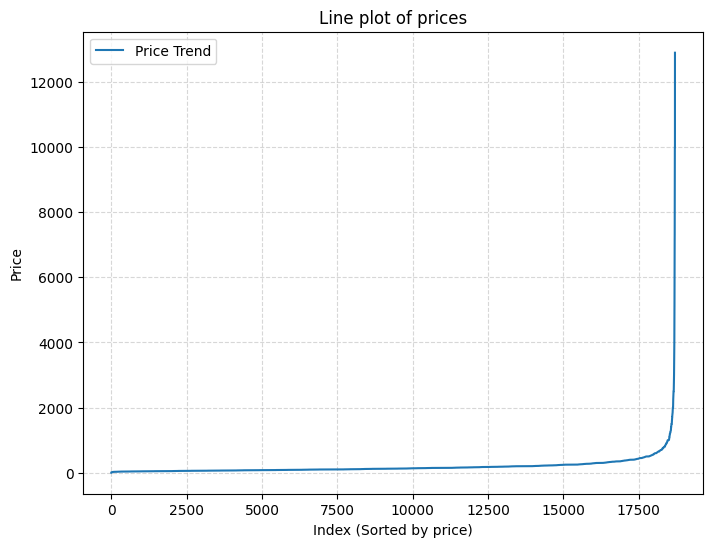

,price
count,18705.000000
mean,191.188292
std,345.350589
min,0.000000
25%,75.000000
50%,125.000000
75%,205.000000
max,12900.000000


In [14]:
print("Recall, that we are interested in the price for a rental from AirBnB.")
print(f"The data type of the target is {type(train_df['price'].loc[0])}\n")
print("This is because the prices include a $ sign. Therefore we should remove these and convert the data to numerical.")
train_df["price"] = train_df["price"].str.replace("$", "").str.replace(",", "").astype(float)
print(f"The data type of the target is now {type(train_df['price'].loc[0])}\n")
print("The distribution of the target in the train set:")
# Sort prices for a line plot
sorted_prices = np.sort(train_df["price"].values)

# Create a line plot
plt.figure(figsize=(8, 6), facecolor="white")
plt.plot(sorted_prices, label="Price Trend")
plt.xlabel("Index (Sorted by price)")
plt.ylabel("Price")
plt.title("Line plot of prices")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

train_df["price"].describe()

In [16]:
print(f"From the analysis, we find that there are some rentals with a price of 0, namely {(train_df['price'] == 0).sum()}.")
print(f"Looking closer at these {(train_df['price'] == 0).sum()} observations, we find that they have quite some missing data as well as no availability for the coming 365 days.")
print("As the price of 0 does not seem reasonable, these observations are excluded from the analysis as they will not provide any helpful insights.")

train_df[train_df["price"] == 0]

From the analysis, we find that there are some rentals with a price of 0, namely 12.
Looking closer at these 12 observations, we find that they have quite some missing data as well as no availability for the coming 365 days.
As the price of 0 does not seem reasonable, these observations are excluded from the analysis as they will not provide any helpful insights.


In [ ]:
train_df = train_df[train_df['price'] != 0]
date_var = ['host_since', 'first_review', 'last_review']

The host_response_rate and the host_acceptance_rate show a percentage, making them non numeric, therefore a similar transformation as for the prices should be done.

In [22]:
train_df["host_response_rate"] = train_df["host_response_rate"].str.replace("%", "").astype(float)
train_df["host_acceptance_rate"] = train_df["host_acceptance_rate"].str.replace("%", "").astype(float)

In [32]:
num_var = ['id', 'host_id', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']
cat_var = ['host_location', 'host_response_time', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'has_availability', 'instant_bookable']

Histograms for numerical variables:

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'host_id'}>,
        <Axes: title={'center': 'host_response_rate'}>,
        <Axes: title={'center': 'host_acceptance_rate'}>,
        <Axes: title={'center': 'host_listings_count'}>,
        <Axes: title={'center': 'latitude'}>],
       [<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'accommodates'}>,
        <Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'beds'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'minimum_nights_avg_ntm'}>],
       [<Axes: title={'center': 'maximum_nights_avg_ntm'}>,
        <Axes: title={'center': 'availability_30'}>,
        <Axes: title={'center': 'availability_60'}>,
        <Axes: title={'center': 'availability_90'}>,
        <Axes: title={'center': 'availability_365'}>,
        <Axes: title={'center': 'number_of_reviews'}>],
       [<Axes: title={'center': 'number_of_reviews_ltm'}>,
        <Axes: title

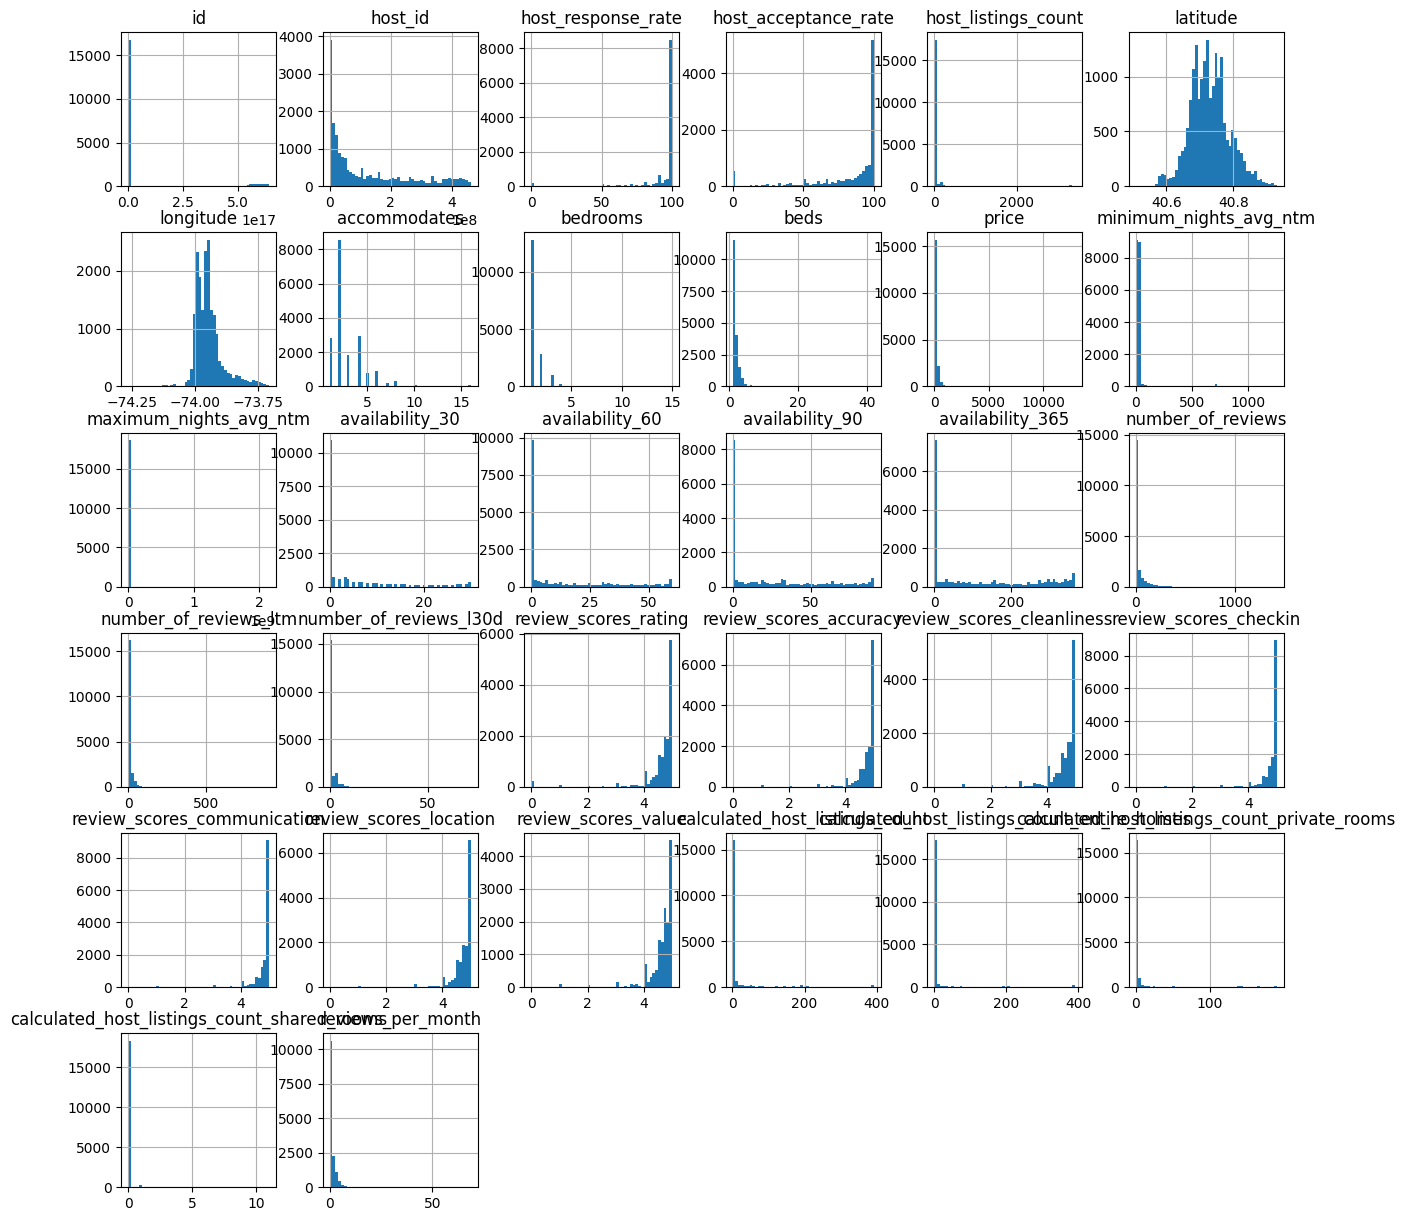

In [33]:
train_df[num_var].hist(bins=50, figsize=(15, 15))

Bar plots for categorical variables:

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20303 (\N{CJK UNIFIED IDEOGRAPH-4F4F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36807 (\N{CJK UNIFIED IDEOGRAPH-8FC7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33521 (\N{CJK UNIFIED IDEOGRAPH-82F1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20262 (\N{CJK UNIFIED IDEOGRAPH-4F26}) missing from font(s) DejaVu Sans.
  fig.canvas

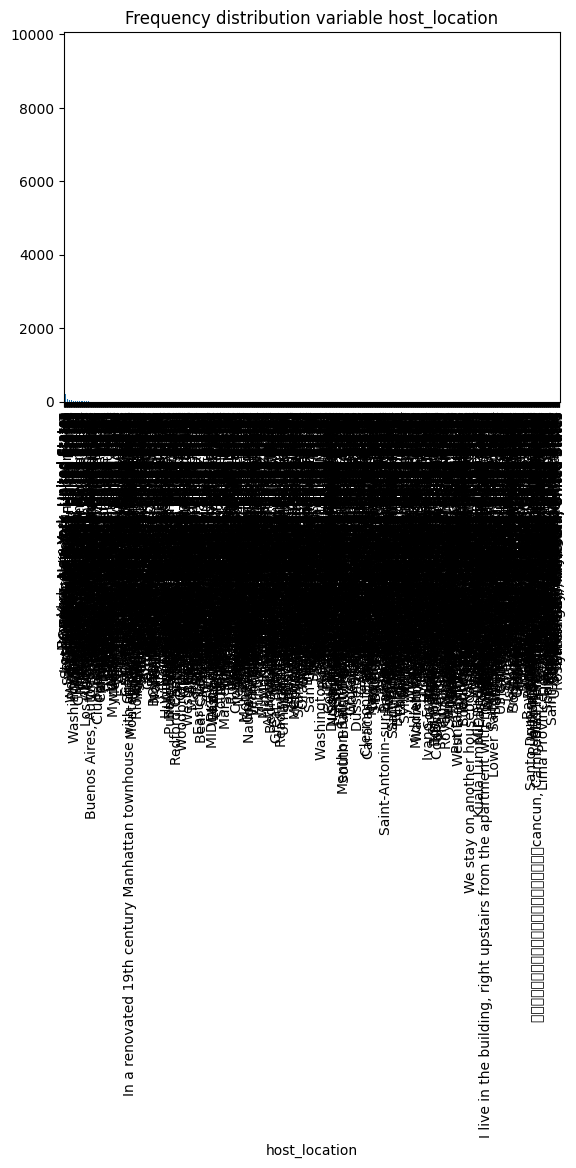

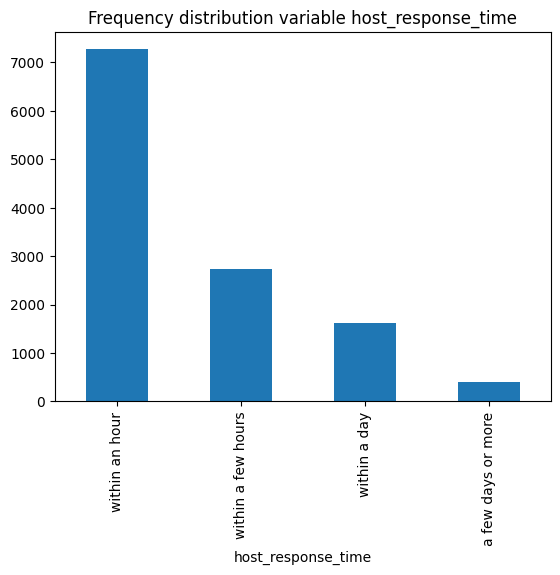

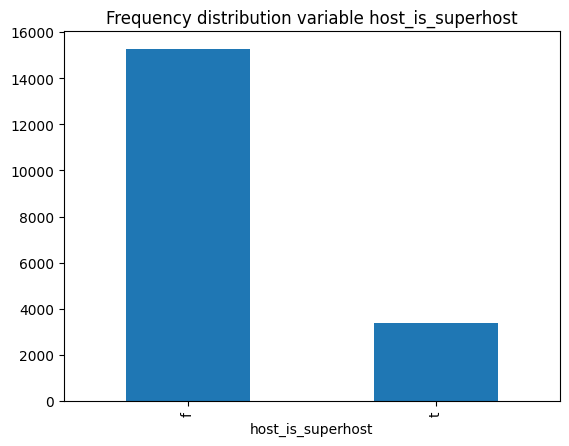

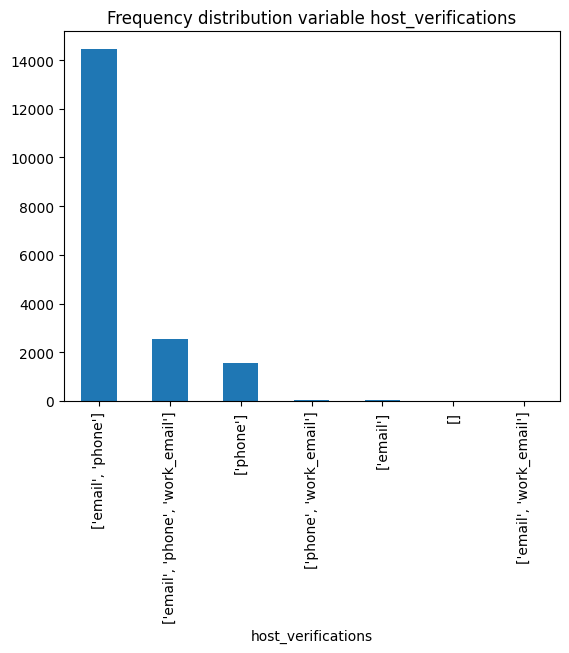

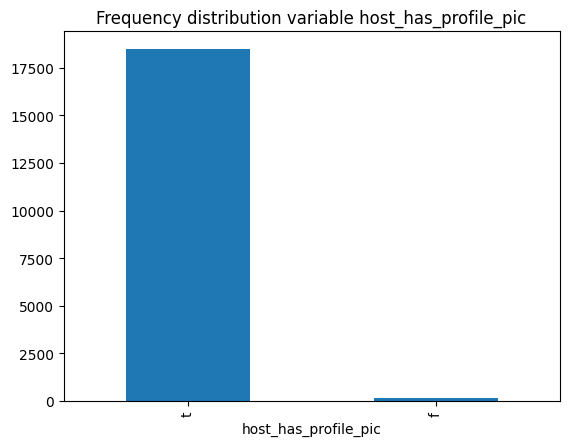

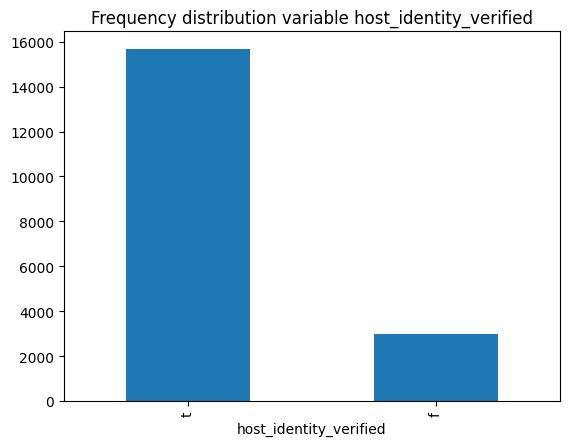

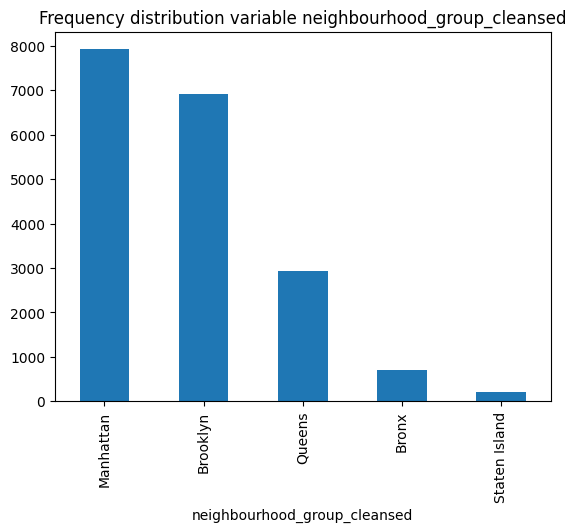

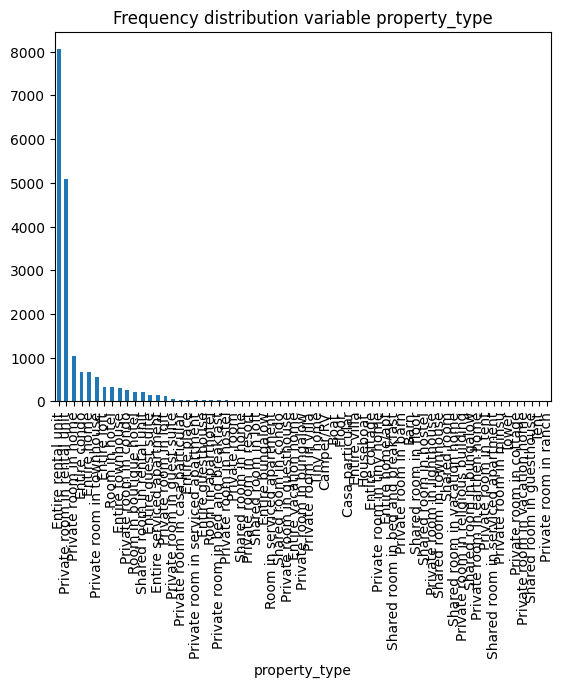

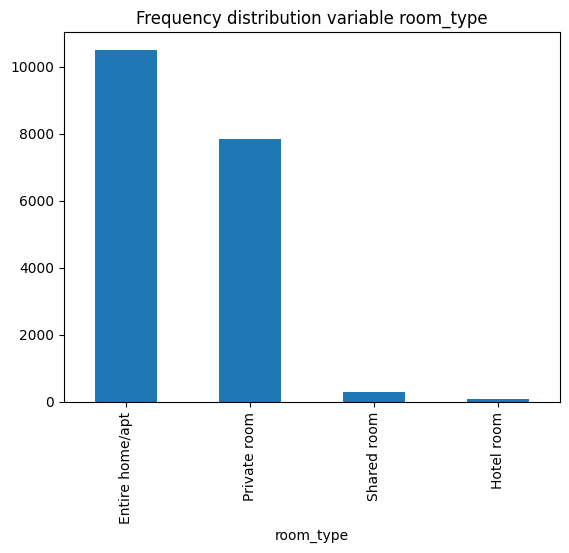

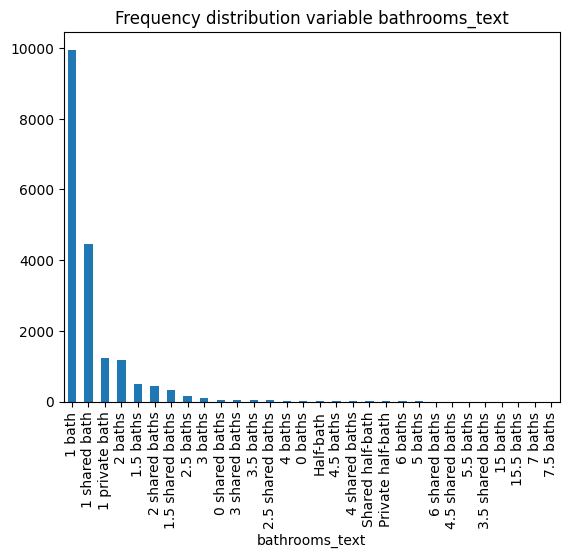

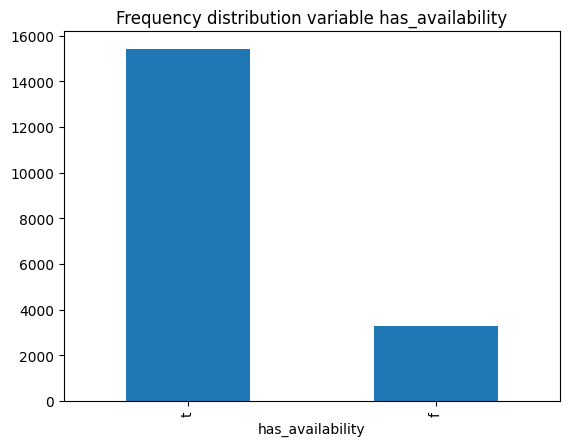

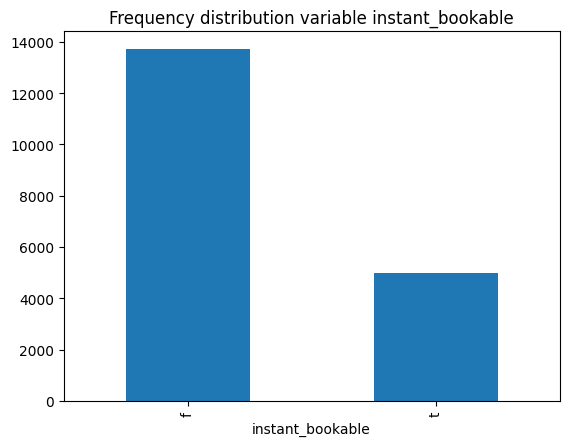

In [34]:
for var in cat_var:
    train_df[var].value_counts().plot(kind="bar", title=f"Frequency distribution variable {var}")
    plt.show()

### 1.4 Bivariate plots

Correlation between variables:

In [35]:
train_df[num_var].corr(method="pearson")

,id,host_id,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,1.000000,0.250119,0.051482,0.103319,0.055464,0.004547,0.072137,0.065606,0.062793,0.043133,0.032561,-0.005860,-0.012331,0.154166,0.187321,0.205245,0.222543,-0.144235,-0.078493,0.087801,0.013330,-0.022335,-0.003925,-0.041694,-0.027876,-0.051586,-0.013859,0.031410,0.022664,0.024075,0.027716,0.240267
host_id,0.250119,1.000000,0.048772,0.173386,-0.003550,0.021620,0.150866,0.063612,0.035682,0.049000,0.028673,-0.060518,0.034398,0.241802,0.274829,0.283331,0.236600,-0.103575,0.118303,0.173438,-0.052648,-0.145533,-0.060130,-0.139465,-0.173433,-0.088528,-0.136330,0.049135,-0.017210,0.133847,0.061751,0.268492
host_response_rate,0.051482,0.048772,1.000000,0.474046,0.064751,-0.023790,0.054282,0.043701,0.020372,0.050376,-0.033441,0.019388,-0.001795,-0.042634,-0.013413,-0.018891,-0.028482,0.089394,0.126473,0.159010,0.106215,0.063955,0.085977,0.067511,0.093938,0.029170,0.078158,0.038448,0.015570,0.051606,0.016083,0.148215
host_acceptance_rate,0.103319,0.173386,0.474046,1.000000,0.050858,-0.007050,0.082741,0.065990,0.010220,0.042212,0.008965,0.005126,0.022639,0.071933,0.103449,0.105258,0.080578,0.139772,0.224882,0.245482,0.039546,0.004361,0.047953,0.014793,0.014463,-0.008220,0.019249,0.084728,0.064881,0.053750,0.030150,0.267986
host_listings_count,0.055464,-0.003550,0.064751,0.050858,1.000000,0.037225,-0.091210,-0.001393,0.004090,-0.013282,0.124435,0.806762,-0.005085,0.074354,0.084626,0.093459,0.140747,-0.068704,-0.050202,-0.054960,-0.013754,-0.036850,-0.018649,-0.005877,-0.053163,0.014550,-0.084554,0.753655,0.763832,0.150956,-0.014663,-0.026284
latitude,0.004547,0.021620,-0.023790,-0.007050,0.037225,1.000000,0.049417,-0.056917,-0.075584,-0.066941,0.026464,0.044483,0.013467,-0.013647,-0.019470,-0.015457,-0.002184,-0.031409,-0.034675,-0.031882,-0.045547,-0.052364,-0.052302,-0.053363,-0.058791,-0.002494,-0.064262,0.070396,0.052814,0.047340,0.030122,-0.034813
longitude,0.072137,0.150866,0.054282,0.082741,-0.091210,0.049417,1.000000,-0.002021,0.009102,0.014823,-0.125135,-0.099629,-0.014716,0.151310,0.169561,0.162542,0.098145,0.051176,0.055610,0.079410,0.009887,-0.007304,0.010579,-0.003300,-0.012641,-0.136117,0.000333,-0.062846,-0.121967,0.099127,0.026290,0.095461
accommodates,0.065606,0.063612,0.043701,0.065990,-0.001393,-0.056917,-0.002021,1.000000,0.744916,0.760423,0.322877,-0.048657,-0.007441,0.116999,0.103867,0.111698,0.139361,0.052814,0.076388,0.073252,0.028731,-0.002875,0.038486,0.008669,0.004573,-0.014822,-0.006094,-0.056768,-0.008162,-0.102700,-0.058126,0.090499
bedrooms,0.062793,0.035682,0.020372,0.010220,0.004090,-0.075584,0.009102,0.744916,1.000000,0.778666,0.274073,-0.014345,-0.017639,0.042640,0.037593,0.055227,0.104551,0.002746,0.033177,0.033625,0.021707,-0.001239,0.033951,0.014164,0.010816,-0.012274,-0.001073,-0.038027,0.008527,-0.086652,-0.047697,0.035966
beds,0.043133,0.049000,0.050376,0.042212,-0.013282,-0.066941,0.014823,0.760423,0.778666,1.000000,0.256145,-0.050763,-0.008558,0.085791,0.076586,0.087382,0.121168,0.056445,0.062726,0.064329,0.024613,-0.000088,0.033672,0.015892,0.010384,-0.015594,0.001552,-0.072368,-0.036324,-0.084138,0.007025,0.067844


<ipython-input-36-0f4783709a0e>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("jet", 30)


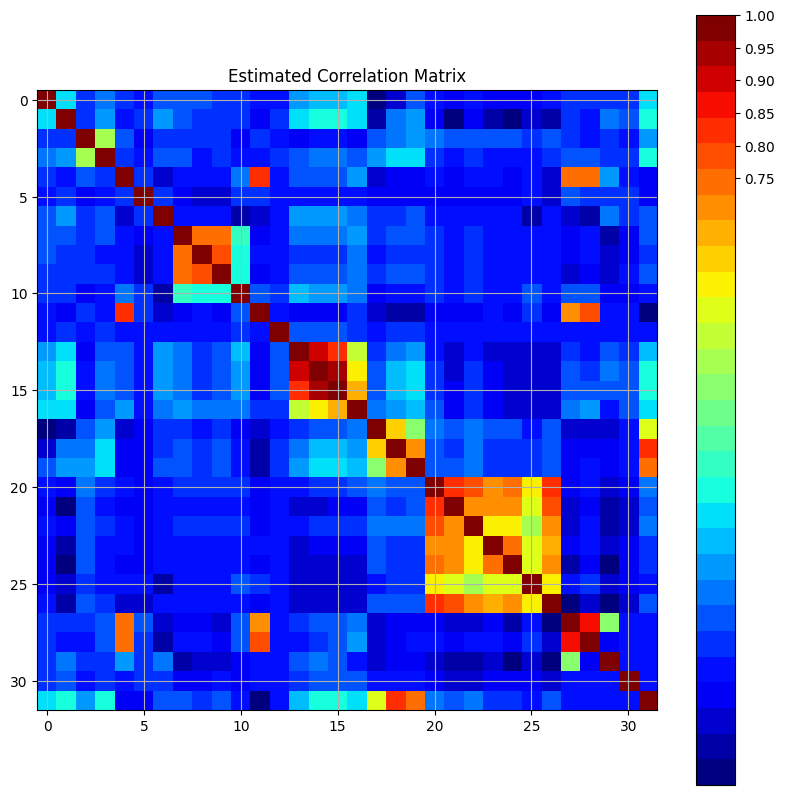

                                    Name feature
0                                             id
1                                        host_id
2                             host_response_rate
3                           host_acceptance_rate
4                            host_listings_count
5                                       latitude
6                                      longitude
7                                   accommodates
8                                       bedrooms
9                                           beds
10                                         price
11                        minimum_nights_avg_ntm
12                        maximum_nights_avg_ntm
13                               availability_30
14                               availability_60
15                               availability_90
16                              availability_365
17                             number_of_reviews
18                         number_of_reviews_ltm
19                  

In [36]:
def VizCorrelationMatrix(df):
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap("jet", 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title("Estimated Correlation Matrix")
    fig.colorbar(cax, ticks=[.75, .8, .85, .90, .95, 1])
    plt.show()
VizCorrelationMatrix(train_df[num_var])
print(pd.DataFrame(num_var, columns=["Name feature"]))

Plots of the relation between price and X:

In [37]:
Z = train_df.copy()
for name in ['host_acceptance_rate', 'host_listings_count', 'latitude', 'longitude', 'accommodates', 'bedrooms']:
    print("Consider feature " + name + ":")
    plt.figure(figsize=(10, 5))
    plt.scatter(Z['bedrooms'], Z['price'], c=Z['Outcome'], cmap='coolwarm')
    plt.xlabel('Bedrooms')
    plt.ylabel('Price')
    plt.title('Scatter Plot: Price vs Bedrooms')
    plt.colorbar()
    plt.show()

    #x = Z.where(Z["Outcome"]==1)[name]
    #y = Z.where(Z["Outcome"]==0)[name]
    #left =min(np.nanmin(x), np.nanmin(y))
    #right =max(np.nanmax(x), np.nanmax(y))
    #plt.hist([x, y], bins=25, range=[left, right], label=['1', '0'], density=True)
    #plt.legend(loc="upper right")
    #plt.show()

Consider feature host_acceptance_rate:


KeyError: 'Outcome'

<Figure size 1000x500 with 0 Axes>

Via box plots:

In [ ]:
for var in num_var:
    train_df.boxplot(column=var, by="Outcome")

Empirical P(Y=1|X=x) for categorical  variables:

In [ ]:
for var in cat_var:
    train_df.groupby(var).agg({"Outcome": "mean"}).plot(kind="bar", title=f"Empirical P(Y=1|X=x) for variable {var}")

Elementary data analysis using pandas-profiling:

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train_df, title="Data report train set")
profile.to_notebook_iframe()

Questions:
*   Can you explain the observed patterns for Monthly_CPI, Monthly_CCI and Euribor3m?
*   What do you think of the data quality?
*   We have used the "train dataset" for the data analysis? Should we have included the "validation set" and "test set" as well? If not: should we carry out additional analyses?
*   Which variables do you consider promising for modelling?


## 2. Feature engineering

Build datasets with dummies for categorical variables:

In [ ]:
def add_dummies(df, cat_var):
    """Return new dataframe with dummy variables for specified categorical variables."""
    dummies_df = pd.DataFrame()
    for var in cat_var:
        aux = pd.get_dummies(df[[var]], prefix=f"ind_{var}", drop_first=False)
        dummies_df = pd.concat([dummies_df, aux], axis=1)
    return dummies_df

def build_X_y(df, num_var, cat_var, name_target):
    """Build datasets X, y for modelling."""
    num_df = df.copy()[num_var]
    dum_df = add_dummies(df, cat_var)
    X = pd.concat([num_df, dum_df], axis=1)
    y = df[name_target]
    return X, y

name_target = "Outcome"
X_train, y_train =  build_X_y(train_df, num_var, cat_var, name_target)
X_validation, y_validation =  build_X_y(validation_df, num_var, cat_var, name_target)
X_test, y_test =  build_X_y(test_df, num_var, cat_var, name_target)
# ensure common columns
cols = list(set(X_train.columns).intersection(set(X_validation.columns)).intersection(set(X_test.columns)))
X_train = X_train[cols]
X_validation = X_validation[cols]
X_test = X_test[cols]

### 2.1 Logit model

Available features:

In [ ]:
print(X_train.columns)

In [ ]:
selected_features = ["ind_Prev_Outcome_success", "ind_Contact_Method_telephone", "ind_Contact_Month_may"]

First we fit a logistic regression using the Scikit-learn package (for machine learning):

In [ ]:
logit = LogisticRegression(penalty="l2")

In [ ]:
logit.fit(X_train[selected_features], y_train)

Estimated coefficients:

In [ ]:
est_coef = pd.DataFrame(logit.coef_.T, index=selected_features, columns=["estimated coefficient"])
est_coef.loc["intercept", "estimated coefficient"] = logit.intercept_
display(est_coef)

The estimated probabilities Y=1:

In [ ]:
probs_train = logit.predict_proba(X_train[selected_features])[:, 1]
plt.hist(probs_train)

In [ ]:
threshold = 0.5
y_pred_train = (logit.predict_proba(X_train[selected_features])[:, 1] > threshold)

In [ ]:
def plot_confusion_matrix(hat_y, y, target_values):
    matrix = confusion_matrix(y, hat_y)  # note that true label corresponds to first argument
    sns.heatmap(matrix.T, square=True, annot=True, fmt="d", cbar=False,
    xticklabels=target_values, yticklabels=target_values)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    accuracy = accuracy_score(y, hat_y, normalize=True, sample_weight=None)
    print("The accuracy is " + str(np.round(100*accuracy,1)) + "%")

plot_confusion_matrix(y_pred_train , y_train, [0, 1])

In [ ]:
def plot_roc(y, hat_prob_y):
    RocCurveDisplay.from_predictions(
        y,
        hat_prob_y,
        name="ROC curve",
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend()
    plt.show()


plot_roc(y_train, probs_train)

**Question**: evaluate performance on validation set

#### Decision tree

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=40)
model_tree = clf.fit(X_train, y_train)
ax = plt.figure(figsize=(25, 25))
tree.plot_tree(model_tree, max_depth=3, filled=True, fontsize=10)

In [ ]:
hat_target_train_tree = model_tree.predict(X_train)

plot_confusion_matrix(hat_target_train_tree, y_train, [0, 1])
plot_roc(y_train,  model_tree.predict_proba(X_train)[:, 1] )

**Question:** evaluate performance on the validation set

Question:  investigate impact of the 'max_depth' parameter.

### Random forest

In [ ]:
clf = RandomForestClassifier(n_estimators=250, random_state=123)
rf = clf.fit(X_train, y_train)

In [ ]:
hat_target_train_rf = rf.predict(X_train)

plot_confusion_matrix(hat_target_train_rf, y_train, [0, 1])
plot_roc(y_train,  rf.predict_proba(X_train)[:, 1] )

**Question:** investigate performance on the validation set.

**Question:** Consider the documentation of Scikit and investigate impact of max_depth.

### Xgboost

In [ ]:
xgb = xgb.XGBClassifier()
xgb.fit(X_train, y_train)

In [ ]:
hat_target_train_xgb = xgb.predict(X_train)

plot_confusion_matrix(hat_target_train_xgb, y_train, [0, 1])
plot_roc(y_train, xgb.predict_proba(X_train)[:, 1] )

**Question**: determine performance on validation set

In [ ]:
hat_target_train_xgb = xgb.predict(X_validation)

plot_confusion_matrix(hat_target_train_xgb, y_validation, [0, 1])
plot_roc(y_validation, xgb.predict_proba(X_validation)[:, 1] )